In [ ]:
#######################################################################################################################
# Project: Deep Virtual Rapport Agent (head gesture detector)
#
#     Jan Ondras (jo951030@gmail.com)
#     Institute for Creative Technologies, University of Southern California
#     April-October 2019
#
#######################################################################################################################
#
#     Test the final fused 4-class (none/nod/shake/tilt) HGD model trained on the whole 4comb dataset on other datasets
#
#     Namely, cross-dataset testing on the ccdb dataset. 
#     Requires the final HGD (./hgd_annotate_frames.ipynb) to be run on the ccdb dataset before.
#
#     Includes the following:
#         Stats of ground truth annotation overlaps in the basic set of the ccdb dataset.
#         Evaluate 4-class fused predictions by HGD on the ccdb dataset, also showing confusion matrices.
#
#     For testing of the nod, shake, and tilt models independently see the script ./evaluate_final_4comb_hgd.ipynb
#
#######################################################################################################################

In [28]:
#######################################################################################################################
# Stats of ground truth annotation overlaps in the basic set of the ccdb dataset
# 
# Ground truth annotation overlap = when a frame is annotated with 2 or more head gestures at a time 
# (e.g. nod and shake at the same time).
# 
# => ground truth annotation overlaps do not present a significant fraction => can neglect/skip such frames
#######################################################################################################################

import glob
import numpy as np
import pandas as pd
from collections import Counter

DATASET_NAME = 'ccdb'
true_annotations_dir = f'/home/ICT2000/jondras/dvra_datasets/{DATASET_NAME}/annotated_features'

ground_truth_overlaps = []

# Iterate over recordings
for true_ann_file in sorted(glob.glob(true_annotations_dir + '/*_*_*_*.csv')):
    
    sessid = true_ann_file.split('/')[-1].split('.')[0]
    print(f'Processing {sessid}')
    true_df = pd.read_csv(true_ann_file)

    ground_truth_overlaps.extend( true_df.apply(lambda row: f"{int(row['nod'])}_{int(row['shake'])}_{int(row['tilt'])}", axis=1) )
    
print('\nnod_shake_tilt')
cnts = Counter(ground_truth_overlaps)
sum_cnts = sum(cnts.values())
for k, v in cnts.items():
    print(f'{k}: {v} ... {100*v/sum_cnts:.4f}%')
overlaps_cnt = (cnts["0_1_1"] + cnts["1_0_1"] + cnts["1_1_0"] + cnts["1_1_1"])
print(f'Overlaps in total: {overlaps_cnt} ... {100*overlaps_cnt/sum_cnts:.4f}%')

Processing P1_P2_1402_C1
Processing P1_P2_1402_C2
Processing P1_P3_1502_C1
Processing P1_P3_1502_C2
Processing P3_P4_1502_C1
Processing P3_P4_1502_C2
Processing P5_P2_1003_C1
Processing P5_P2_1003_C2
Processing P5_P3_2202_C1
Processing P5_P3_2202_C2
Processing P6_P2_1602_C1
Processing P6_P2_1602_C2
Processing P6_P3_1602_C1
Processing P6_P3_1602_C2
Processing P6_P4_1602_C1
Processing P6_P4_1602_C2

nod_shake_tilt
0_0_0: 133399 ... 93.6515%
1_0_0: 6327 ... 4.4418%
0_1_0: 1638 ... 1.1499%
0_0_1: 750 ... 0.5265%
0_1_1: 196 ... 0.1376%
1_0_1: 43 ... 0.0302%
1_1_1: 88 ... 0.0618%
1_1_0: 1 ... 0.0007%
Overlaps in total: 328 ... 0.2303%


In [1]:
#######################################################################################################################
# Evaluate 4-class (none/nod/shake/tilt) fused predictions by HGD on the CCDb dataset
# 
#     (preprocess data in this cell and plot confusion matrices in the next cell)
#
# To fuse the ccdb ground truth annotations into 0/1/2/3 labels, we skip the frames annotated with 2 or more 
# head gestures at a time (e.g. nod and shake at the same time). See the reasoning in the above cell. 
#######################################################################################################################

import glob
import numpy as np
import pandas as pd
from collections import defaultdict

DATASET_NAME = 'ccdb'
true_annotations_dir = f'/home/ICT2000/jondras/dvra_datasets/{DATASET_NAME}/annotated_features'
pred_annotations_dir = f'/home/ICT2000/jondras/dvra_datasets/{DATASET_NAME}/hgd_annotated_features'

def ground_truth_fusion(row):
    # Fusion of ground truth annotations into 0/1/2/3 labels
    return np.argmax([0, row['nod'], row['shake'], row['tilt']])

y_true = []
y_pred = defaultdict(list)

# Iterate over recordings
for true_ann_file in sorted(glob.glob(true_annotations_dir + '/*_*_*_*.csv')):
    
    sessid = true_ann_file.split('/')[-1].split('.')[0]
    print(f'Processing {sessid}')
    
    true_df = pd.read_csv(true_ann_file)
    pred_df = pd.read_csv(pred_annotations_dir + f'/{sessid}.csv')
    assert len(true_df) == len(pred_df)
    org_df_size = len(true_df)    
    
    # Skip frames with multiple head gesture annotations in ground truths
    indexes_to_keep = np.where((true_df['nod'] + true_df['shake'] + true_df['tilt'] < 2))[0]
    true_df = true_df.iloc[indexes_to_keep]
    pred_df = pred_df.iloc[indexes_to_keep]
    print(f'\tskipped {org_df_size - len(true_df)}/{org_df_size} frames')
        
    y_true.extend( true_df.apply(ground_truth_fusion, axis=1) )
    
    y_pred['head_gesture_max_probab_NS'].extend( pred_df['head_gesture_max_probab_NS'] )
    y_pred['head_gesture_max_probab'].extend( pred_df['head_gesture_max_probab'] )
    y_pred['head_gesture_unique_NS'].extend( pred_df['head_gesture_unique_NS'] )
    y_pred['head_gesture_unique'].extend( pred_df['head_gesture_unique'] )
    
#     break

Processing P1_P2_1402_C1
	skipped 0/8821 frames
Processing P1_P2_1402_C2
	skipped 0/8821 frames
Processing P1_P3_1502_C1
	skipped 64/9805 frames
Processing P1_P3_1502_C2
	skipped 71/8915 frames
Processing P3_P4_1502_C1
	skipped 0/8901 frames
Processing P3_P4_1502_C2
	skipped 43/8901 frames
Processing P5_P2_1003_C1
	skipped 0/8571 frames
Processing P5_P2_1003_C2
	skipped 0/8571 frames
Processing P5_P3_2202_C1
	skipped 0/8951 frames
Processing P5_P3_2202_C2
	skipped 88/8951 frames
Processing P6_P2_1602_C1
	skipped 0/8851 frames
Processing P6_P2_1602_C2
	skipped 0/8851 frames
Processing P6_P3_1602_C1
	skipped 0/8825 frames
Processing P6_P3_1602_C2
	skipped 62/8825 frames
Processing P6_P4_1602_C1
	skipped 0/8941 frames
Processing P6_P4_1602_C2
	skipped 0/8941 frames


Normalized confusion matrix


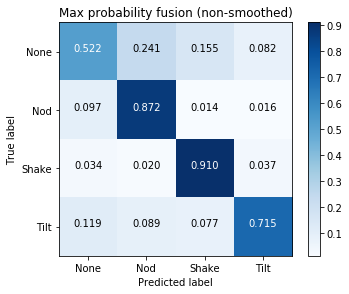

Recall: 0.5432399341373827
Precision: 0.9360818445593223
F1: 0.6546629948009215

Normalized confusion matrix


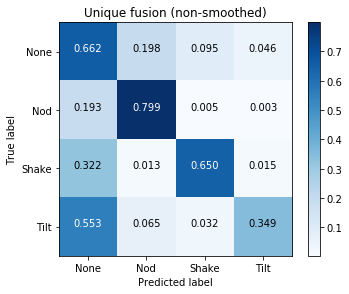

Recall: 0.665894985715693
Precision: 0.924447111347626
F1: 0.7541276923248904

Normalized confusion matrix


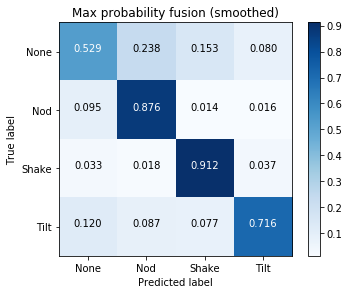

Recall: 0.5496150977384353
Precision: 0.9365270836099255
F1: 0.6601689672542163

Normalized confusion matrix


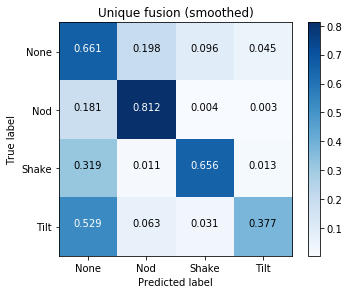

Recall: 0.666584572948478
Precision: 0.9255477555065331
F1: 0.7545617314797356



In [3]:
#######################################################################################################################
# Plot confusion matrices using the data preprocessed in the above cell
#######################################################################################################################

from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_cm(true_ann, pred_ann, title):
    
    class_names = ['None', 'Nod', 'Shake', 'Tilt']
#     plt.figure(figsize=(3.,3.))
    plt.figure()
    rot = 0
    
    cm = confusion_matrix(true_ann, pred_ann) #.astype(np.float)
#     print(cm)
    normalize = True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=rot)
    plt.yticks(tick_marks, class_names)
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(f'Recall: {recall_score(true_ann, pred_ann, average="weighted")}')
    print(f'Precision: {precision_score(true_ann, pred_ann, average="weighted")}')
    print(f'F1: {f1_score(true_ann, pred_ann, average="weighted")}')
    print()
        
    
plot_cm(y_true, y_pred['head_gesture_max_probab_NS'], title='Max probability fusion (non-smoothed)')
plot_cm(y_true, y_pred['head_gesture_unique_NS'], title='Unique fusion (non-smoothed)')
          
plot_cm(y_true, y_pred['head_gesture_max_probab'], title='Max probability fusion (smoothed)')
plot_cm(y_true, y_pred['head_gesture_unique'], title='Unique fusion (smoothed)')